## Imports

In [2]:
# utils
import os
import sys
from pathlib import Path
PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))

# basics
import numpy as np
import pandas as pd

# viz
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

# metrics
from utils import config
from utils.reader import read_file_yaml

np.random.seed(0)

## Parameters

In [6]:
path_root = (
    PROJECT_DIR
    / "results"
)
path_conf = (
    PROJECT_DIR
    / "conf"
)
file_path_parameters = (
    path_conf 
    / "parameters.yml"
)
path_outputs = (
    PROJECT_DIR
    / "outputs"
)
params = read_file_yaml(file_path_parameters)
if not os.path.exists(path_outputs):
    os.makedirs(path_outputs)
    
file_path_simulation_plot = (
    path_outputs
    / params["outputs"]["simulation_random"]["filepath"]
)
    
file_path_plot_i_dataset = (
    path_outputs
    / params["outputs"]["simulation_random"]["data_filepath"]
)
n_random = np.sort([int(i.replace("random_n",""))for i in os.listdir(path_root) if ".placehold"not in i])
path_random = [
    "random_n"+str(i) for i in n_random
]
path_results = [path_root / i for i in path_random]

In [7]:
under_line = "\n{}\n"
title_part_n2 = "PROJECT_DIR: [ {} ]".format(PROJECT_DIR)
title_part_n3 = under_line.format(
    "".join(["-"]*len(title_part_n2))
)
title_part_n1 = under_line.format(
    "".join(["-"]*len(title_part_n2))
)
print(title_part_n1 + title_part_n2 + title_part_n3)


----------------------------------------------------
PROJECT_DIR: [ /home/manuel/aaai-claire-clustering ]
----------------------------------------------------



## Read

In [8]:
parameters = read_file_yaml(file_path_parameters)

In [9]:
path_metrics = []
for name, url in zip(path_random, path_results):
    _path_metrics = [
        [f"{name}_{dataset}", os.path.getmtime(url / dataset / "metrics" / "metrics.csv")]
        for dataset in os.listdir(url)
    ]
    path_metrics = path_metrics + _path_metrics
init = int(pd.DataFrame(path_metrics).sort_values(1).iloc[0,0].split("_")[1][1:])

In [10]:
metrics = {
    name: {
        dataset: pd.read_csv(
            url / dataset / "metrics" / "metrics.csv",
            index_col = 0
        ) for dataset in os.listdir(url)
    }
    for name, url in zip(path_random, path_results)
}

## Concat all results

In [94]:
data = (
    metrics[f"random_n{init}"]["aniso"]
    .T
    .filter(regex="^(?!.*random_model)")
    .T[["abilities"]]
    .reset_index()
)

data.rename(columns={
    "abilities": f"n{init}_aniso",
    "index": "model"
}, inplace=True)


for random_n, content_n in metrics.items():
    for name, content_dataset in content_n.items():
        if (random_n == f"random_n{init}") and (name == "aniso"):
            continue
        tmp = (
            content_dataset
            .T
            .filter(regex="^(?!.*random_model)")
            .T[["abilities"]]
            .reset_index()
        )

        tmp.rename(columns={
            "abilities": "n{}_{}".format(
                random_n.replace("random_n", ""),
                name
            ),
            "index": "model"
        }, inplace=True)

        data = data.merge(tmp, on="model", how="outer")

data.set_index("model", inplace=True)

In [96]:
datasets = {}
for i in config.file_names:
    datasets[i] = data.filter(regex = r"{}".format(i))
    datasets[i].columns = datasets[i].columns.str.replace("_"+i, "")

## Plots

In [97]:
models = list(config.models.keys())+["average_model", "optimal_clustering"]
gray_scale = [str(i/len(models)) for i in range(1, len(models))]
colors = plt.cm.coolwarm(np.linspace(0, 1, len(models)))
markers = list(mlines.Line2D.markers.keys())

_params = {
    _model: {
        "color": colors[_idx],
        "marker": markers[_idx],
        "linestyle": '--' 
    } for _idx, _model in enumerate(models)
}
handler_lines = [
    Line2D([], [], 
           color = param["color"],
           linestyle = param["linestyle"],
           marker = param["marker"]) for param in _params.values()
    ]

In [105]:
## by dataset
figs_dataset = {}
for name, content in datasets.items():
    _fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    content = content.dropna()
    for line_name, line_data in content.iterrows():
        for idx, i in enumerate(models):
            if i in line_name:
                _line_index = []
                for k in line_data.index.str.split("n"):
                    _line_index.append("$p_{("+k[1]+")}$")
                linestyle = '--'
                ax.plot(_line_index, line_data, **_params[i])
                _line_index = []
    ax.grid(True)
    ax.set_title(name)
    ax.set_ylabel("$abilities$")
    ax.set_xlabel('$n\_random\_model$')
    ax.legend(handler_lines, models, loc='upper left', bbox_to_anchor=(1.00, 1.0))
    figs_dataset[name] = _fig
    plt.ioff()

In [125]:
## global plot
fig, axes = plt.subplots(len(datasets.keys()), 1, figsize=(20, 8*len(datasets)))

if not isinstance(axes, np.ndarray):
    axes = [axes]

for ax, (name, content) in zip(axes, datasets.items()):
    content = content.dropna()
    for line_name, line_data in content.iterrows():
        for idx, i in enumerate(models):
            if i in line_name:
                _line_index = []
                for k in line_data.index.str.split("n"):
                    _line_index.append("$p_{("+k[1]+")}$")
                linestyle = '--'
                ax.plot(_line_index, line_data, **_params[i])
                _line_index = []
    ax.grid(True)
    ax.set_title(name)
    ax.set_ylabel("$abilities$")

axes[-1].set_xlabel('$n\_random\_model$')
handler_lines = [Line2D([], [], color=param["color"], linestyle=param["linestyle"], marker=param["marker"]) for param in _params.values()]
axes[0].legend(handler_lines, models, loc='upper left', bbox_to_anchor=(1.00, 1.0))
plt.ioff()

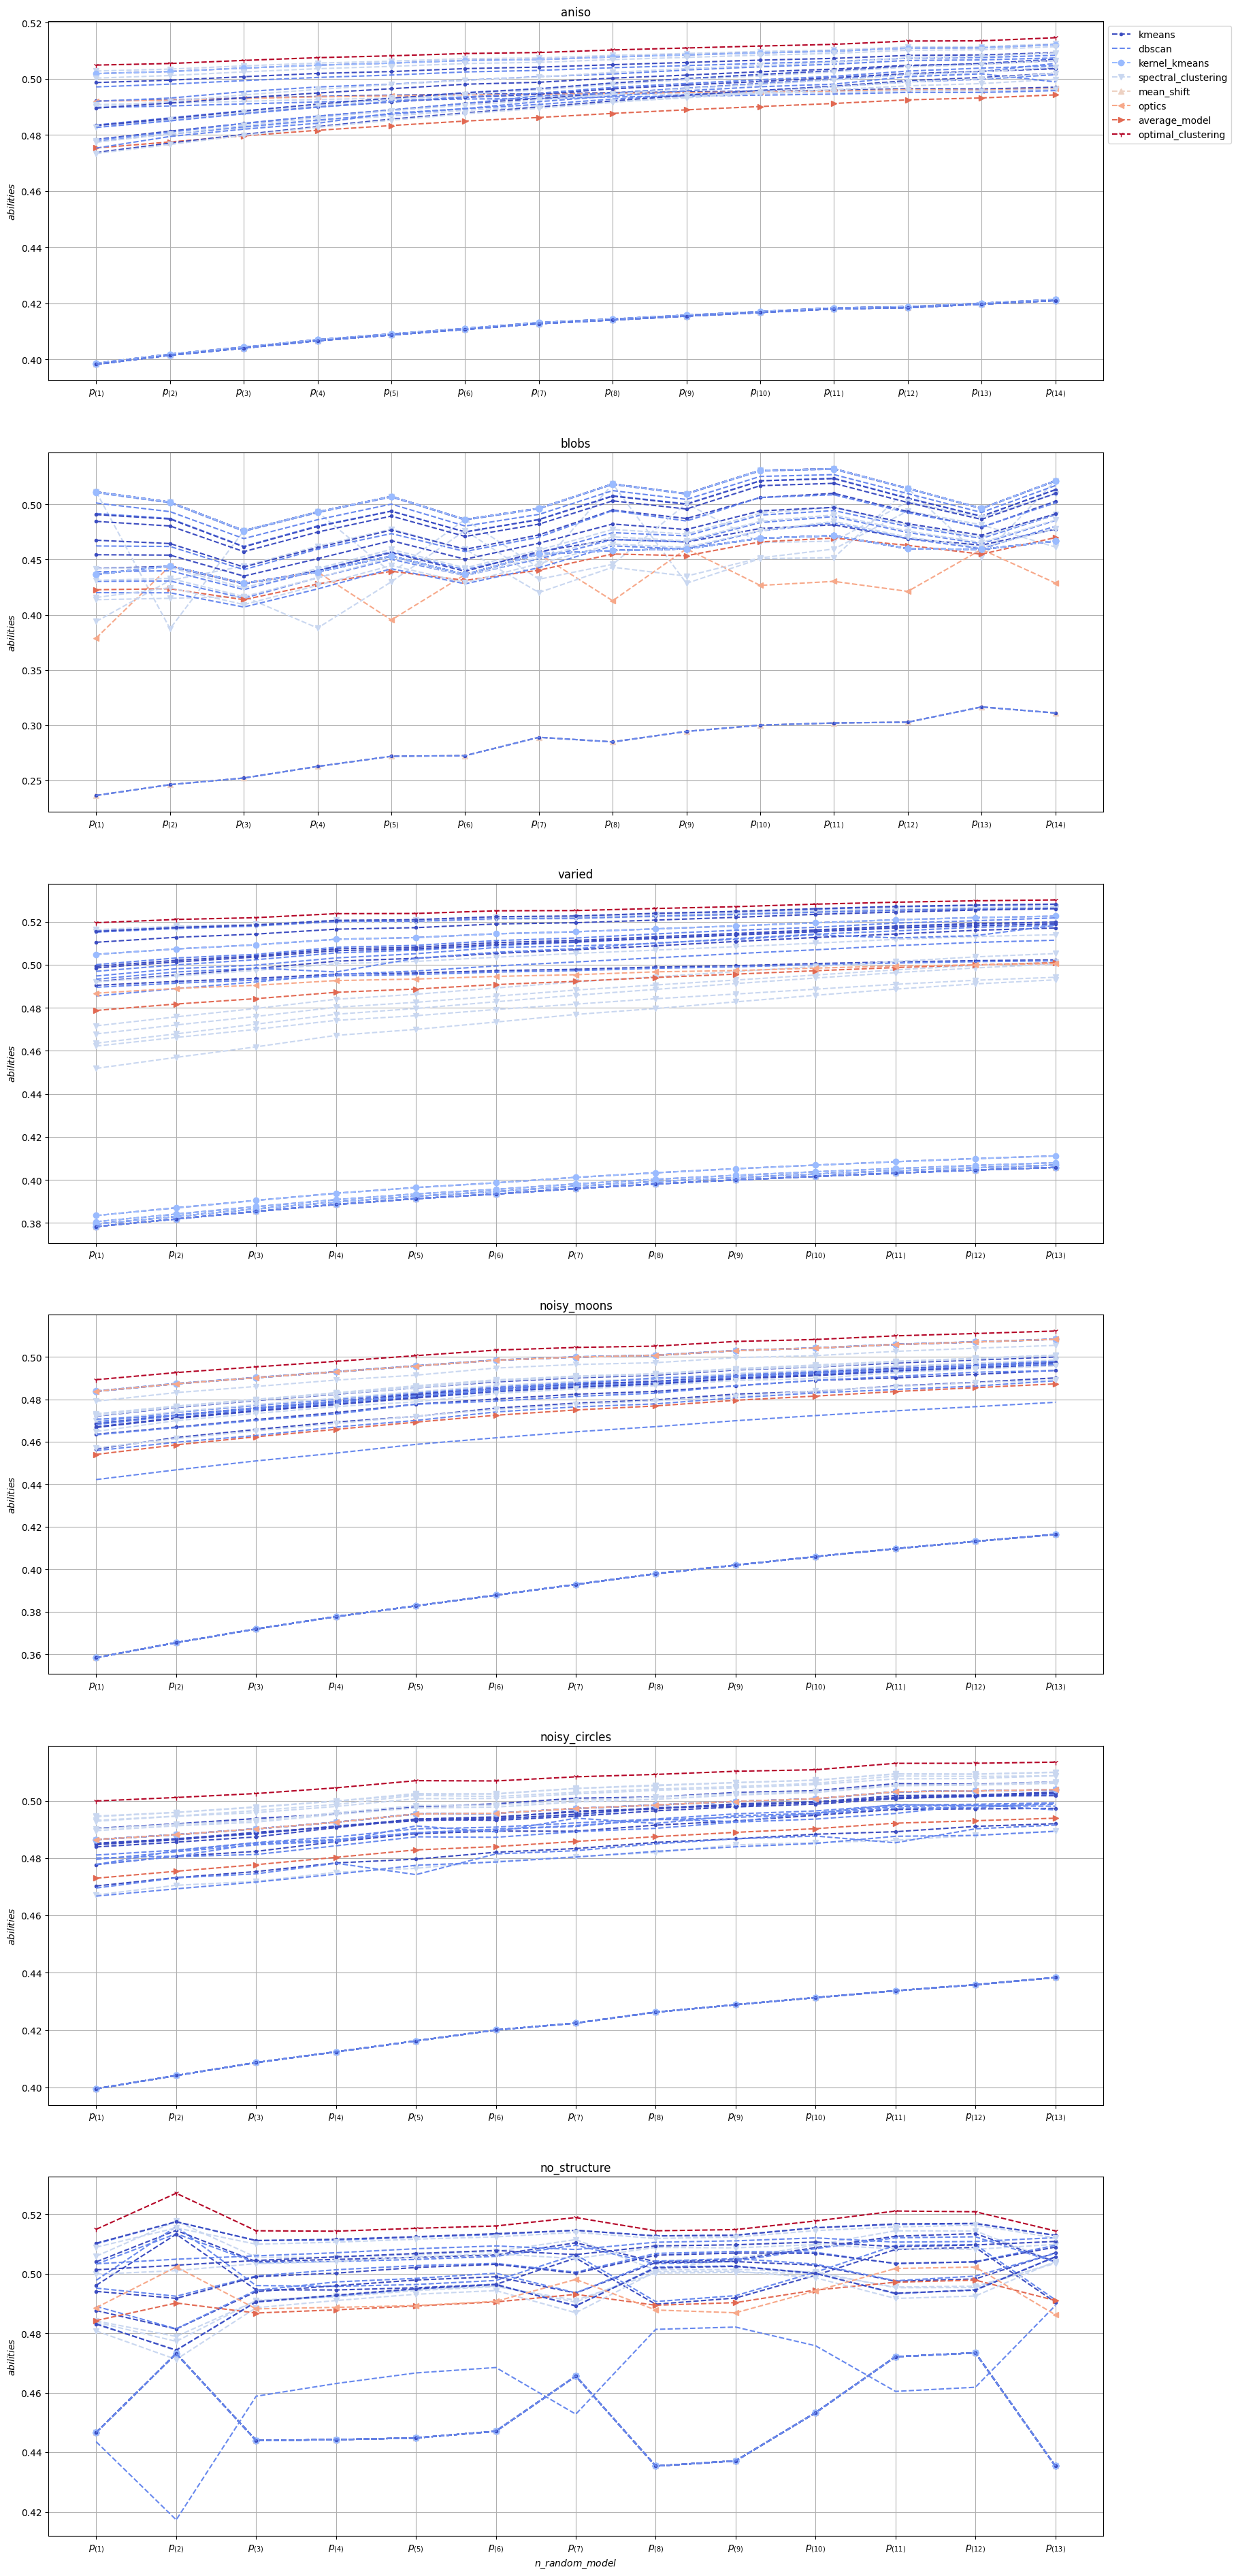

In [126]:
fig

## Save

In [ ]:
fig.savefig(str(file_path_simulation_plot)+".eps") # save eps format
fig.savefig(str(file_path_simulation_plot)+".png") # save png format

In [ ]:
for name, content in figs_dataset.items():
    content.savefig(str(file_path_plot_i_dataset).format(name)+".eps") # save eps format
    content.savefig(str(file_path_plot_i_dataset).format(name)+".png") # save png format